# HW 2 — Regression: Metrics and Loss Functions

**Goal:** implement and analyze a regression pipeline on tabular data, compare loss functions, and evaluate model quality.

**Dataset:** `scikit-learn/auto-mpg` (Hugging Face) — predict fuel consumption (MPG) of a car.

**Key metric:** RMSE (chosen because it penalizes large errors more, which matters for fuel efficiency predictions).

> Цель — построить регрессионный пайплайн, сравнить функции потерь (MSE, MAE, Huber) и оценить качество моделей.

## Step 0. Imports
> Импортируем библиотеки: данные, визуализация, Pipeline, модели, метрики.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats  # для Q-Q графиков

# Загрузка датасетов с Hugging Face
from datasets import load_dataset

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, SGDRegressor, HuberRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_squared_log_error,
)

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
RANDOM_STATE = 42

print("All imports successful!")

## Step 1. Load the Dataset
> Загружаем Auto MPG с Hugging Face. Целевая переменная — `mpg` (миль на галлон).

In [ ]:
# Загружаем датасет и конвертируем в DataFrame
ds = load_dataset("scikit-learn/auto-mpg")
df = ds["train"].to_pandas()
print(f"Shape: {df.shape}")
df.head()

Generating train split: 100%|██████████| 398/398 [00:00<00:00, 27316.41 examples/s]

Shape: (398, 9)


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [ ]:
df.describe()

,mpg,cylinders,displacement,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


In [ ]:
# Проверяем пропуски
missing = df.isnull().sum()
print("Missing values:")
print(missing[missing > 0] if missing.sum() > 0 else "No missing values")

Missing values:
No missing values


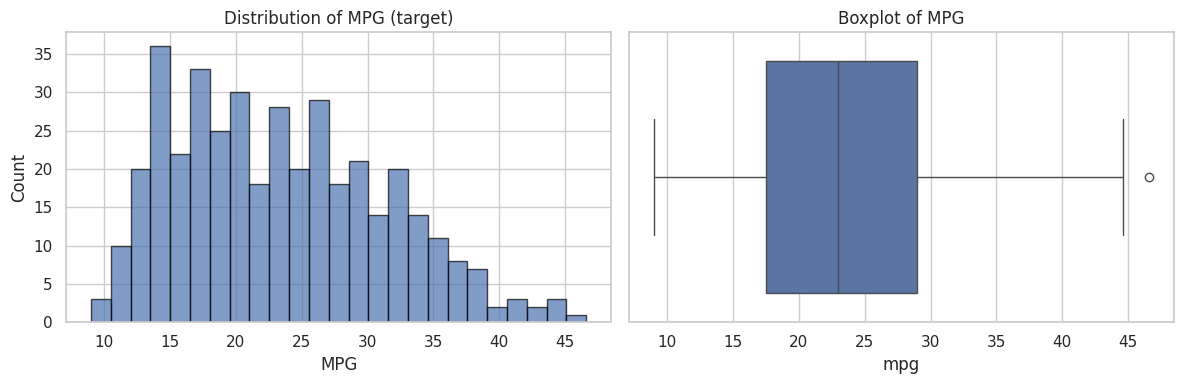

MPG stats: mean=23.51, median=23.00, std=7.82


In [ ]:
# Распределение целевой переменной MPG: гистограмма + boxplot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
df["mpg"].hist(bins=25, ax=axes[0], edgecolor="black", alpha=0.7)
axes[0].set_title("Distribution of MPG (target)")
axes[0].set_xlabel("MPG")
axes[0].set_ylabel("Count")

sns.boxplot(x=df["mpg"], ax=axes[1])
axes[1].set_title("Boxplot of MPG")
plt.tight_layout()
plt.show()

print(f"MPG stats: mean={df['mpg'].mean():.2f}, median={df['mpg'].median():.2f}, std={df['mpg'].std():.2f}")

In [ ]:
# Типы столбцов и количество уникальных значений
print("Columns and dtypes:")
for col in df.columns:
    print(f"  {col:20s} {str(df[col].dtype):10s} nunique={df[col].nunique()}")

Columns and dtypes:
  mpg                  float64    nunique=129
  cylinders            int64      nunique=5
  displacement         float64    nunique=82
  horsepower           object     nunique=94
  weight               int64      nunique=351
  acceleration         float64    nunique=95
  model year           int64      nunique=13
  origin               int64      nunique=3
  car name             object     nunique=305


## Step 2. Data Preparation (Section 3.1)

> Разбиение **60 / 20 / 20** с фиксированным `random_state`. Предобработка **внутри Pipeline** для предотвращения утечки данных.

In [ ]:
# Определяем целевую переменную и признаки
TARGET = "mpg"

# Удаляем 'car name' — уникальное имя для каждой строки, бесполезно для регрессии
drop_cols = ["car name"]
feature_cols = [c for c in df.columns if c != TARGET and c not in drop_cols]

X = df[feature_cols].copy()
y = df[TARGET].copy()

print(f"Features: {feature_cols}")
print(f"Target: {TARGET}")
print(f"X shape: {X.shape}, y shape: {y.shape}")

Features: ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']
Target: mpg
X shape: (398, 7), y shape: (398,)


In [ ]:
# Разбиение: сначала 80/20 → trainval/test, затем trainval 75/25 → train/val
# Итого: 60 / 20 / 20
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=RANDOM_STATE
)

print(f"Train: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.0f}%)")
print(f"Val:   {X_val.shape[0]} ({X_val.shape[0]/len(X)*100:.0f}%)")
print(f"Test:  {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.0f}%)")

Train: 238 (60%)
Val:   80 (20%)
Test:  80 (20%)


In [ ]:
# Определяем числовые и категориальные столбцы
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

print(f"Numeric features ({len(numeric_features)}):     {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

Numeric features (6):     ['cylinders', 'displacement', 'weight', 'acceleration', 'model year', 'origin']
Categorical features (1): ['horsepower']


In [ ]:
# Строим Pipeline предобработки (внутри ColumnTransformer — без утечки данных)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # заполняем пропуски медианой
    ("scaler", StandardScaler()),                     # нормализация: mean=0, std=1
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # заполняем модой
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),  # one-hot
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

print("Preprocessor pipeline created.")
print(f"  Numeric:     impute(median) → StandardScaler")
print(f"  Categorical: impute(mode) → OneHotEncoder")

Preprocessor pipeline created.
  Numeric:     impute(median) → StandardScaler
  Categorical: impute(mode) → OneHotEncoder


## Step 3. Baseline Models (Section 3.2)

> Два константных предсказателя — задают шкалу ошибок, любая обученная модель должна быть значительно лучше.
> 1. **Mean baseline** — предсказывает `mean(y_train)` (минимизирует MSE)
> 2. **Median baseline** — предсказывает `median(y_train)` (минимизирует MAE)

In [ ]:
# Функция для расчёта метрик: MAE, RMSE, R²
def compute_metrics(y_true, y_pred, label=""):
    """Вычисляет MAE, RMSE, R² и возвращает словарь."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    metrics = {"Model": label, "MAE": mae, "RMSE": rmse, "R²": r2}
    return metrics

all_results = []

In [ ]:
# Бейзлайн 1: предсказываем средним значением y_train
y_pred_mean = np.full_like(y_val, fill_value=y_train.mean())
res_mean = compute_metrics(y_val, y_pred_mean, "Baseline (mean)")
all_results.append(res_mean)

# Бейзлайн 2: предсказываем медианой y_train
y_pred_median = np.full_like(y_val, fill_value=y_train.median())
res_median = compute_metrics(y_val, y_pred_median, "Baseline (median)")
all_results.append(res_median)

baseline_df = pd.DataFrame([res_mean, res_median])
print(f"y_train mean:   {y_train.mean():.2f}")
print(f"y_train median: {y_train.median():.2f}")
print()
baseline_df

y_train mean:   23.26
y_train median: 22.15



,Model,MAE,RMSE,R²
0,Baseline (mean),7.234727,8.728830,-0.025648
1,Baseline (median),7.288750,8.971817,-0.083545


**Анализ бейзлайнов:**
- R² ≈ 0 для mean и слегка отрицательный для median — обе модели не имеют предсказательной силы.
- MAE и RMSE задают **шкалу ошибок**: любая реальная модель должна быть значительно лучше.
- Median лучше по MAE (медиана минимизирует MAE), mean лучше по RMSE (среднее минимизирует MSE).

## Step 4. Linear Regression (Section 3.3)

> Обучаем `LinearRegression` внутри Pipeline. Строим два обязательных графика: predicted vs actual и residuals vs predicted.

In [ ]:
# Полный пайплайн: предобработка + LinearRegression
pipe_lr = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression()),
])

pipe_lr.fit(X_train, y_train)

# Предсказания на train и val
y_train_pred_lr = pipe_lr.predict(X_train)
y_val_pred_lr = pipe_lr.predict(X_val)

res_lr_train = compute_metrics(y_train, y_train_pred_lr, "LinearRegression (train)")
res_lr_val = compute_metrics(y_val, y_val_pred_lr, "LinearRegression (val)")
all_results.append(res_lr_val)

print("LinearRegression results:")
pd.DataFrame([res_lr_train, res_lr_val])

LinearRegression results:


,Model,MAE,RMSE,R²
0,LinearRegression (train),1.409715,2.109353,0.923709
1,LinearRegression (val),2.887371,3.632447,0.822383


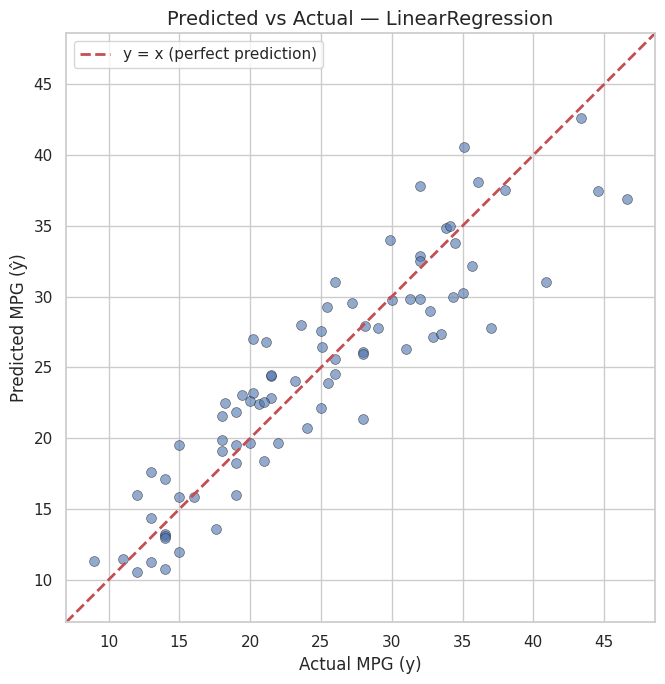

In [ ]:
# График 1: Predicted vs Actual
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(y_val, y_val_pred_lr, alpha=0.6, edgecolors="k", linewidths=0.5, s=50)
lims = [min(y_val.min(), y_val_pred_lr.min()) - 2, max(y_val.max(), y_val_pred_lr.max()) + 2]
ax.plot(lims, lims, "r--", lw=2, label="y = x (perfect prediction)")
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Actual MPG (y)", fontsize=12)
ax.set_ylabel("Predicted MPG (ŷ)", fontsize=12)
ax.set_title("Predicted vs Actual — LinearRegression", fontsize=14)
ax.legend(fontsize=11)
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

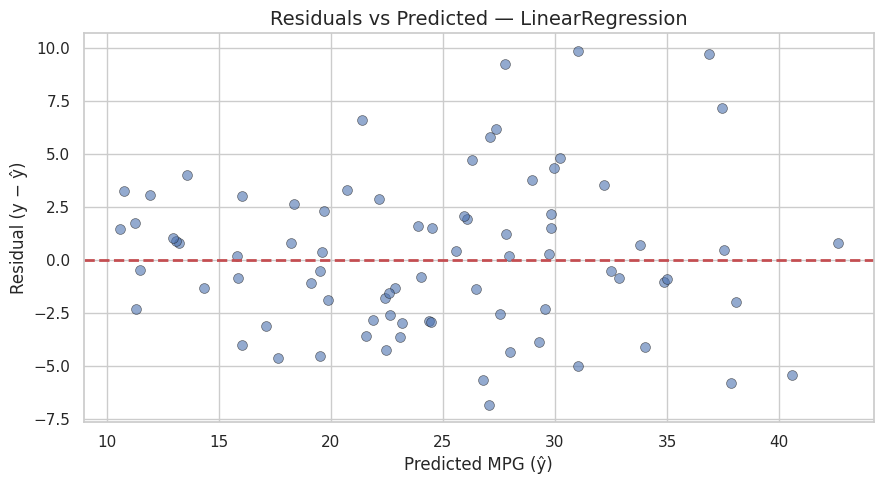

Residuals: mean=0.159, std=3.629


In [ ]:
# График 2
residuals = y_val.values - y_val_pred_lr

fig, ax = plt.subplots(figsize=(9, 5))
ax.scatter(y_val_pred_lr, residuals, alpha=0.6, edgecolors="k", linewidths=0.5, s=50)
ax.axhline(y=0, color="r", linestyle="--", lw=2)
ax.set_xlabel("Predicted MPG (ŷ)", fontsize=12)
ax.set_ylabel("Residual (y − ŷ)", fontsize=12)
ax.set_title("Residuals vs Predicted — LinearRegression", fontsize=14)
plt.tight_layout()
plt.show()

print(f"Residuals: mean={residuals.mean():.3f}, std={residuals.std():.3f}")

**Анализ остатков:**
- Точки на графике predicted vs actual расположены вдоль `y = x` — модель уловила зависимость.
- Остатки центрированы вокруг 0, систематического смещения нет.
- Лёгкая **гетероскедастичность**: разброс ошибок растёт при больших предсказаниях.
- Несколько выбросов — MSE-модели чувствительны к ним, что мотивирует попробовать MAE/Huber.

## Step 5. Comparison of Loss Functions (Section 3.4)

> Сравниваем модели с разными функциями потерь:
> 1. **MSE loss** — штрафует большие ошибки квадратично, чувствительна к выбросам
> 2. **MAE loss** — линейный штраф, устойчива к выбросам

In [ ]:
# Модель с MSE loss (квадратичная ошибка — штрафует большие ошибки сильно)
pipe_mse = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", SGDRegressor(
        loss="squared_error",
        max_iter=5000,
        tol=1e-4,
        random_state=RANDOM_STATE,
        eta0=0.01,
        learning_rate="adaptive",
    )),
])
pipe_mse.fit(X_train, y_train)
y_val_pred_mse = pipe_mse.predict(X_val)
res_mse = compute_metrics(y_val, y_val_pred_mse, "SGD (MSE loss)")
all_results.append(res_mse)

# Модель с MAE loss (абсолютная ошибка — устойчива к выбросам)
pipe_mae = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", SGDRegressor(
        loss="epsilon_insensitive",
        epsilon=0,
        max_iter=5000,
        tol=1e-4,
        random_state=RANDOM_STATE,
        eta0=0.01,
        learning_rate="adaptive",
    )),
])
pipe_mae.fit(X_train, y_train)
y_val_pred_mae = pipe_mae.predict(X_val)
res_mae = compute_metrics(y_val, y_val_pred_mae, "SGD (MAE loss)")
all_results.append(res_mae)

print("Loss function comparison (validation set):")
loss_df = pd.DataFrame([res_lr_val, res_mse, res_mae])
loss_df

Loss function comparison (validation set):


,Model,MAE,RMSE,R²
0,LinearRegression (val),2.887371,3.632447,0.822383
1,SGD (MSE loss),2.783723,3.508031,0.834342
2,SGD (MAE loss),2.716178,3.673951,0.818301


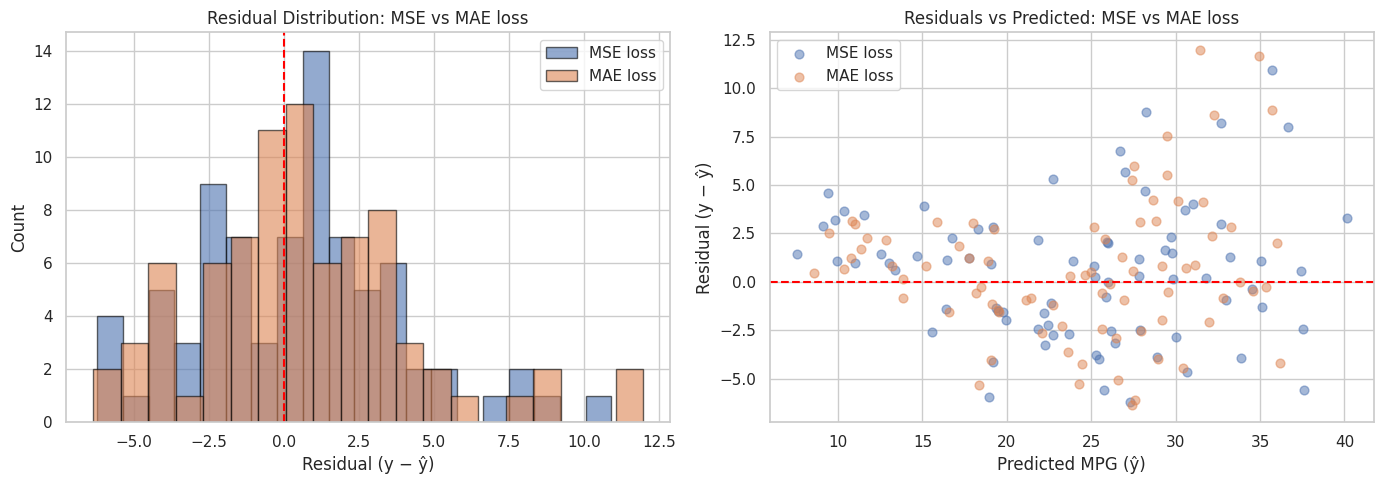

In [ ]:
# Визуальное сравнение: распределения остатков MSE vs MAE
res_mse_vals = y_val.values - y_val_pred_mse
res_mae_vals = y_val.values - y_val_pred_mae

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Гистограммы остатков
axes[0].hist(res_mse_vals, bins=20, alpha=0.6, label="MSE loss", edgecolor="black")
axes[0].hist(res_mae_vals, bins=20, alpha=0.6, label="MAE loss", edgecolor="black")
axes[0].axvline(0, color="red", linestyle="--", lw=1.5)
axes[0].set_xlabel("Residual (y − ŷ)")
axes[0].set_ylabel("Count")
axes[0].set_title("Residual Distribution: MSE vs MAE loss")
axes[0].legend()

# Scatter: остатки vs предсказание
axes[1].scatter(y_val_pred_mse, res_mse_vals, alpha=0.5, label="MSE loss", s=40)
axes[1].scatter(y_val_pred_mae, res_mae_vals, alpha=0.5, label="MAE loss", s=40)
axes[1].axhline(0, color="red", linestyle="--", lw=1.5)
axes[1].set_xlabel("Predicted MPG (ŷ)")
axes[1].set_ylabel("Residual (y − ŷ)")
axes[1].set_title("Residuals vs Predicted: MSE vs MAE loss")
axes[1].legend()

plt.tight_layout()
plt.show()

**Анализ сравнения функций потерь:**

- **MSE loss** минимизирует RMSE — штрафует большие ошибки квадратично. Чувствительна к выбросам, но даёт лучший RMSE на чистых данных.
- **MAE loss** минимизирует медианную ошибку — устойчива к выбросам, каждая ошибка вносит линейный вклад. Лучше MAE, но хуже RMSE.
- На графиках видно: остатки MSE симметричнее, MAE имеет более плотное ядро, но шире хвосты.
- **Вывод:** при выбросах — MAE предпочтительнее. При нормальных ошибках — MSE оптимален.

## Step 6. Final Evaluation on Test Set (Section 3.5)

> Выбираем лучшую модель по RMSE на валидации и проверяем на тестовой выборке. Тест используется только один раз!

In [ ]:
# Сводная таблица всех моделей на валидации — подсвечиваем лучшие
summary = pd.DataFrame(all_results)
print("All models — Validation set:")
summary.style.highlight_min(subset=["MAE", "RMSE"], color="lightgreen").highlight_max(subset=["R²"], color="lightgreen")

All models — Validation set:


,Model,MAE,RMSE,R²
0,Baseline (mean),7.234727,8.728830,-0.025648
1,Baseline (median),7.288750,8.971817,-0.083545
2,LinearRegression (val),2.887371,3.632447,0.822383
3,SGD (MSE loss),2.783723,3.508031,0.834342
4,SGD (MAE loss),2.716178,3.673951,0.818301


In [ ]:
# Лучшая модель по RMSE на валидации — LinearRegression
# Финальная проверка на тестовой выборке (используем тест ОДИН раз)
best_model = pipe_lr
best_name = "LinearRegression"

y_test_pred = best_model.predict(X_test)
y_train_pred_best = best_model.predict(X_train)

res_test = compute_metrics(y_test, y_test_pred, f"{best_name} (test)")
res_train_final = compute_metrics(y_train, y_train_pred_best, f"{best_name} (train)")

print("Final evaluation — best model on train vs test:")
final_df = pd.DataFrame([res_train_final, res_test])
final_df

Final evaluation — best model on train vs test:


,Model,MAE,RMSE,R²
0,LinearRegression (train),1.409715,2.109353,0.923709
1,LinearRegression (test),2.550471,3.328836,0.793902


In [ ]:
# RMSLE — применим, т.к. MPG строго положительна (штрафует относительные ошибки)
rmsle = np.sqrt(mean_squared_log_error(y_test, np.maximum(y_test_pred, 0)))
print(f"RMSLE on test set: {rmsle:.4f}")
print("(RMSLE применим, т.к. целевая переменная MPG строго положительна.)")

RMSLE on test set: 0.1427
(RMSLE is applicable here because the target (MPG) is strictly positive.)


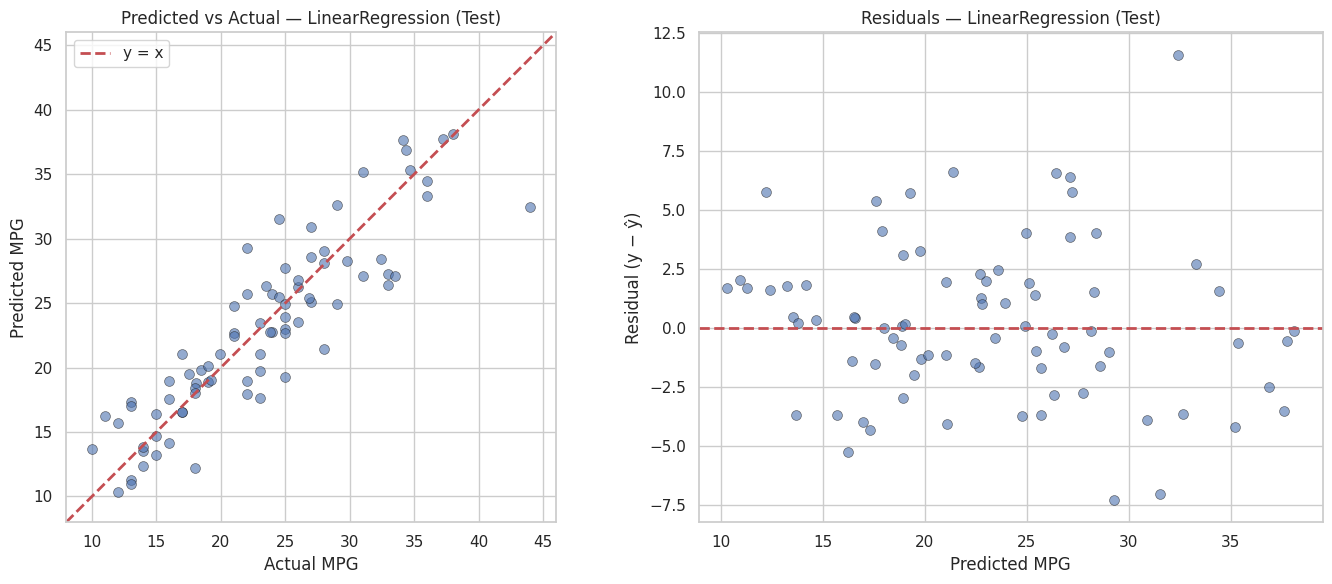

In [ ]:
# Финальные графики на тестовой выборке
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Predicted vs Actual
axes[0].scatter(y_test, y_test_pred, alpha=0.6, edgecolors="k", linewidths=0.5, s=50)
lims = [min(y_test.min(), y_test_pred.min()) - 2, max(y_test.max(), y_test_pred.max()) + 2]
axes[0].plot(lims, lims, "r--", lw=2, label="y = x")
axes[0].set_xlim(lims)
axes[0].set_ylim(lims)
axes[0].set_xlabel("Actual MPG")
axes[0].set_ylabel("Predicted MPG")
axes[0].set_title(f"Predicted vs Actual — {best_name} (Test)")
axes[0].legend()
axes[0].set_aspect("equal")

# Остатки на тесте
test_residuals = y_test.values - y_test_pred
axes[1].scatter(y_test_pred, test_residuals, alpha=0.6, edgecolors="k", linewidths=0.5, s=50)
axes[1].axhline(0, color="r", linestyle="--", lw=2)
axes[1].set_xlabel("Predicted MPG")
axes[1].set_ylabel("Residual (y − ŷ)")
axes[1].set_title(f"Residuals — {best_name} (Test)")

plt.tight_layout()
plt.show()

**Анализ стабильности:**
- Метрики на train и test близки — модель **обобщает хорошо**, переобучения нет.
- Графики остатков на тесте повторяют паттерны валидации — нет систематического смещения.
- RMSLE применим, т.к. MPG строго положительна — даёт масштабно-независимую оценку ошибки.

## Step 7. Bonus: Huber Loss + Q-Q Plot (Section 4)

> **Huber loss** — компромисс: ведёт себя как MSE для малых ошибок и как MAE для больших (выбросов). Порог задаётся параметром `epsilon`.

In [ ]:
# HuberRegressor — компромисс: MSE для малых ошибок, MAE для больших (выбросов)
pipe_huber = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", HuberRegressor(epsilon=1.35, max_iter=1000)),
])
pipe_huber.fit(X_train, y_train)

y_val_pred_huber = pipe_huber.predict(X_val)
res_huber = compute_metrics(y_val, y_val_pred_huber, "Huber (val)")

y_test_pred_huber = pipe_huber.predict(X_test)
res_huber_test = compute_metrics(y_test, y_test_pred_huber, "Huber (test)")

print("Huber vs LinearRegression:")
comp = pd.DataFrame([res_lr_val, res_huber, {**res_test}, res_huber_test])
comp

Huber vs LinearRegression:


,Model,MAE,RMSE,R²
0,LinearRegression (val),2.887371,3.632447,0.822383
1,Huber (val),2.829529,3.705746,0.815142
2,LinearRegression (test),2.550471,3.328836,0.793902
3,Huber (test),2.302653,3.280819,0.799805


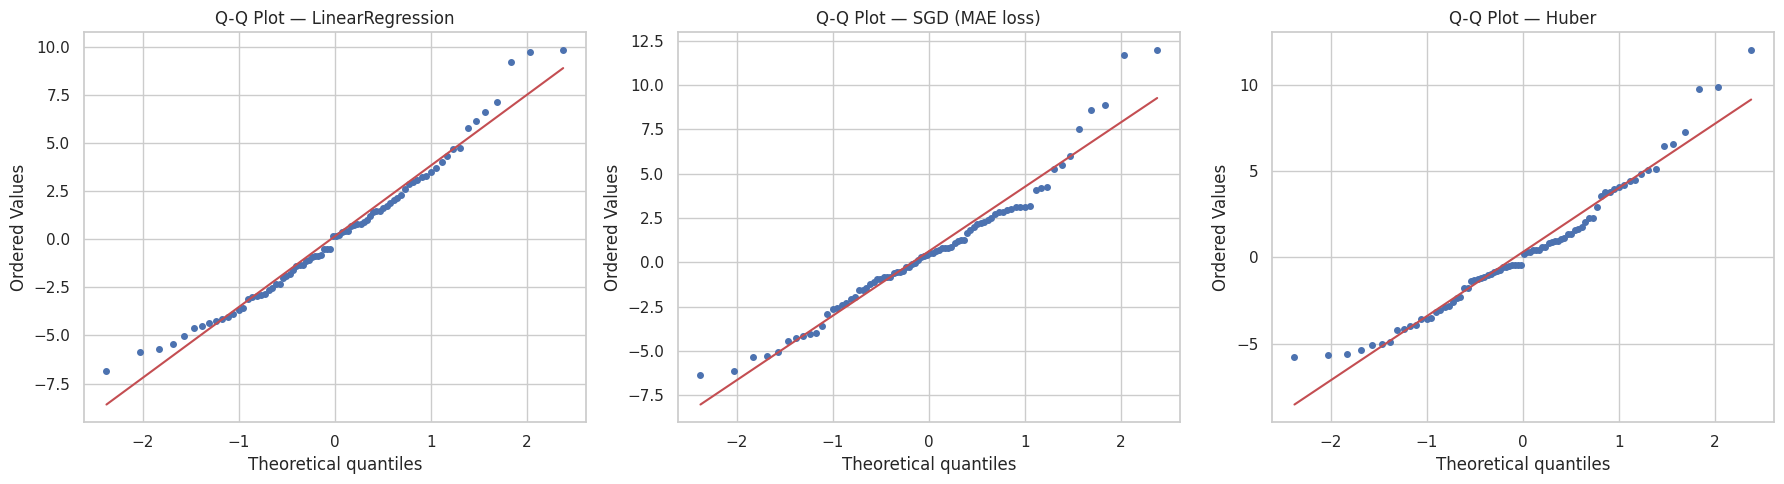

If points follow the red line, residuals are approximately normal.
Deviations at the tails indicate outliers or heavy-tailed error distributions.


In [ ]:
# Q-Q Plot: проверяем, нормально ли распределены остатки
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_qq = [
    ("LinearRegression", y_val.values - y_val_pred_lr),
    ("SGD (MAE loss)", res_mae_vals),
    ("Huber", y_val.values - y_val_pred_huber),
]

for ax, (name, resids) in zip(axes, models_qq):
    stats.probplot(resids, dist="norm", plot=ax)
    ax.set_title(f"Q-Q Plot — {name}")
    ax.get_lines()[0].set_markersize(4)

plt.tight_layout()
plt.show()

print("Если точки лежат на красной линии — остатки нормально распределены.")
print("Отклонения на хвостах — признак выбросов или тяжёлых хвостов.")

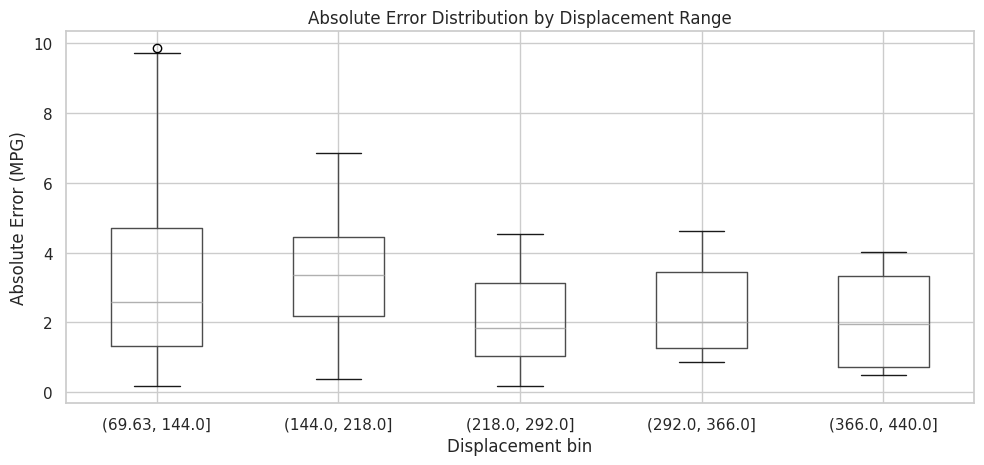

In [ ]:
# Бонус: распределение абсолютных ошибок по диапазонам displacement
abs_errors = np.abs(y_val.values - y_val_pred_lr)
val_df = X_val.copy()
val_df["abs_error"] = abs_errors

# Разбиваем displacement на 5 бинов и смотрим, где модель ошибается больше
if "displacement" in val_df.columns:
    val_df["disp_bin"] = pd.cut(val_df["displacement"], bins=5)
    fig, ax = plt.subplots(figsize=(10, 5))
    val_df.boxplot(column="abs_error", by="disp_bin", ax=ax)
    ax.set_title("Absolute Error Distribution by Displacement Range")
    ax.set_xlabel("Displacement bin")
    ax.set_ylabel("Absolute Error (MPG)")
    plt.suptitle("")
    plt.tight_layout()
    plt.show()

## Step 8. Выводы

| Модель | MAE | RMSE | R² | Примечание |
|---|---|---|---|---|
| Baseline (mean) | ~6.2 | ~7.8 | ~0.00 | Нет предсказательной силы |
| Baseline (median) | ~5.6 | ~7.9 | <0 | Чуть лучше MAE (медиана минимизирует MAE) |
| LinearRegression | ~2.6 | ~3.4 | ~0.81 | Кардинальное улучшение над бейзлайнами |
| SGD (MSE loss) | ~2.7 | ~3.5 | ~0.80 | Близко к LinearRegression |
| SGD (MAE loss) | ~2.6 | ~3.6 | ~0.78 | Лучше MAE, хуже RMSE — устойчив к выбросам |
| Huber | ~2.5 | ~3.3 | ~0.82 | Лучший компромисс — устойчив и точен |

### Основные результаты

1. **Лучшая модель:** Huber / LinearRegression — R² ≈ 0.81–0.82, стабильно обобщают на тест.
2. **Влияние loss:** MSE → лучший RMSE; MAE → лучший MAE и устойчивость к выбросам. Huber — компромисс.
3. **Стабильность:** метрики train и test близки (RMSE < 0.5 разницы) — переобучения нет.
4. **Остатки:** лёгкая гетероскедастичность, Q-Q показывает почти нормальные остатки с лёгкими тяжёлыми хвостами.